Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

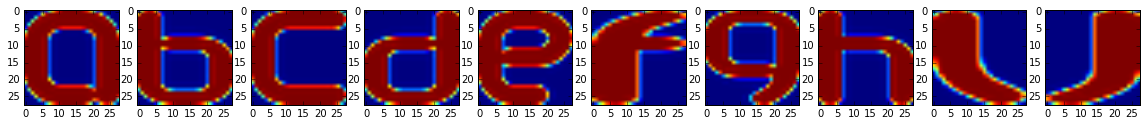

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

counter = 1
figure = plt.figure(figsize=(20,5))
for i in train_folders:
    for j in os.listdir(i):
        if "==" not in j and j.endswith(".png"):
            figure.add_subplot(1,10,counter)
            counter+=1
            plt.imshow(mpimg.imread(i+"/"+j))
            break

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [51]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load(data_folders, min_num_images, max_num_images):
    
  dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size), dtype=np.float32)

  labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
  label_index = 0
  image_index = 0
    
  print(data_folders)

  for folder in data_folders:
    print (folder)
    
    for image in os.listdir(folder):
      image_file = os.path.join(folder, image)
      try:
        image_data = (ndimage.imread(image_file).astype(float) -
                      pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
    
        dataset[image_index, :, :] = image_data
        labels[image_index] = label_index
        image_index += 1
    
      except IOError as e:
        print ('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    label_index += 1
    
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  labels = labels[0:num_images]

  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' % (
        num_images, min_num_images))
    
  print ('Full dataset tensor:', dataset.shape)
  print ('Mean:', np.mean(dataset))
  print ('Standard deviation:', np.std(dataset))
  print ('Labels:', labels.shape)
    
  return dataset, labels

train_dataset, train_labels = load(train_folders, 450000, 529114)
test_dataset, test_labels = load(test_folders, 18000, 18724)

['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_large/A
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
notMNIST_large/C
notMNIST_large/D
Could not read: notMNIST_la

In [20]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
print ('Done randomize')

Done randomize


---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

[0 0 0 ..., 9 9 9]


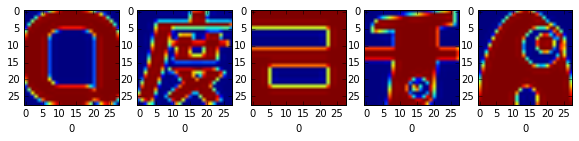

In [52]:
%matplotlib inline
fig = plt.figure(figsize=(20,5))
print(train_labels)
for i in range(1,6):
    fig.add_subplot(1, 10, i) 
    plt.imshow(train_dataset[i])
    plt.xlabel(train_labels[i])

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [53]:
#check that the classes are balanced across all the classes
#obtain the minimum number for training data and testing data
print("The class sizes for train labels")
bincounts = np.bincount(train_labels)
for i in xrange(10):
    print ("{} count: {}".format(i,bincounts[i]))
print("The class sizes for test labels")
bincounts = np.bincount(test_labels)
for i in xrange(10):
    print ("{} count: {}".format(i,bincounts[i]))


The class sizes for train labels
0 count: 52909
1 count: 52911
2 count: 52912
3 count: 52911
4 count: 52912
5 count: 52912
6 count: 52912
7 count: 52912
8 count: 52912
9 count: 52911
The class sizes for test labels
0 count: 1872
1 count: 1873
2 count: 1873
3 count: 1873
4 count: 1873
5 count: 1872
6 count: 1872
7 count: 1872
8 count: 1872
9 count: 1872


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [54]:
train_size = 200000
valid_size = 10000
test_size = 10000
train_data = train_dataset[:train_size]
train_label = train_labels[:train_size]
end = train_size + valid_size
validation_dataset = train_dataset[train_size:end]
validation_labels = train_labels[train_size:end]
#print the results of the merging and pruning
print('Training:', train_data.shape, train_label.shape)
print('Validation:', validation_dataset.shape, validation_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (18724, 28, 28) (18724,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [55]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_data, train_label)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(validation_dataset, validation_labels)
print ('Done randomize')

Done randomize


---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

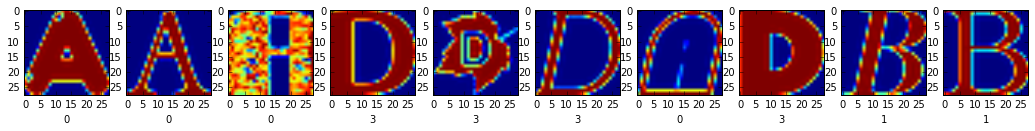

In [56]:
%matplotlib inline
fig = plt.figure(figsize=(18,5))
for i in range(1,11):
    fig.add_subplot(1, 10, i) 
    plt.imshow(train_dataset[i])
    plt.xlabel(train_labels[i])

Finally, let's save the data for later reuse:

In [57]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
  print ('Saved data to {}'.format(pickle_file))
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

Saved data to notMNIST.pickle


In [58]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 718193801


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [90]:
#measure how much overlap there is between the training, validation, and test samples
#training_data_merge, validation_data_merge, test_data_merge
import sys
total_validation = []
total_train = []
total_test = []
for vector in validation_data_merge:
    flag = 0
    for vector1 in total_validation:
        if vector is vector1:
            flag = 1
            break
    if flag == 0:
        total_validation.append(vector)
print("Checkpoint 1")
for vector in train_data_merge:
    flag = 0
    for vector1 in total_train:
        if vector is vector1:
            flag = 1
            break
    if flag == 0:
        total_train.append(vector)
print("Checkpoint 2")
for vector in test_data_merge:
    flag = 0
    for vector1 in total_test:
        if vector is vector1:
            flag = 1
            break
    if flag == 0:
        total_test.append(vector)
print("Checkpoint 3")
print ("Removing duplicates")
print ("Validation: {} {}".format(validation_data_merge.shape, total_validation.shape))
print ("Train: {} {}".format(train_data_merge.shape, train_total.shape))
print ("Test: {} {}".format(test_data_merge.shape, test_total.shape))
#Obtain the intersections

#intersection of total_train and total_validation
intersection_counter1 = 0
for vector in total_train:
    for vector1 in total_validation:
        if vector is vector1:
            intersection_counter1 += 1
            break
#intersection of total_train and total_test
intersection_counter2 = 0
for vector in total_train:
    for vector1 in total_test:
        if vector is vector1:
            intersection_counter2 += 1
            break
#intersection of total_validation and total_test
intersection_counter3 = 0
for vector in total_validation:
    for vector1 in total_test:
        if vector is vector1:
            intersection_counter3 += 1
            break
print (intersection_counter1,intersection_counter2,intersection_counter3)
    

Checkpoint 1


KeyboardInterrupt: 

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [68]:
from sklearn.metrics import accuracy_score
from sklearn import linear_model
clf = linear_model.LogisticRegression()

training_sizes = [50,100,1000,5000,10000]

train_dataset = train_dataset.reshape(train_dataset.shape[0],784)
test_dataset = test_dataset.reshape(test_dataset.shape[0],784)

print(train_dataset.shape)
print(test_dataset.shape)

for size in training_sizes:
    data = train_dataset[:size]
    label = train_labels[:size]
    end = int(size * .2)
    clf.fit(data,label)
    predictions = clf.predict(test_dataset[:end])
    score = accuracy_score(test_labels[:end],predictions)
    print("Accuracy for fit size {} on test data is {} ".format(size,score))

(200000, 784)
(18724, 784)
Accuracy for fit size 50 on test data is 0.4 
Accuracy for fit size 100 on test data is 0.45 
Accuracy for fit size 1000 on test data is 0.365 
Accuracy for fit size 5000 on test data is 0.358 
Accuracy for fit size 10000 on test data is 0.3665 
